<a href="https://colab.research.google.com/github/brunocu/DataScience/blob/master/Titanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
train_df = pd.read_csv('drive/My Drive/DataScience/train.csv')
test_df = pd.read_csv('drive/My Drive/DataScience/test.csv')
combine = [train_df, test_df]

In [0]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Los datos estadísticos de algunas categorías en `train_df.describe()` no representan nada real.

Por ejemplo: `PassengerId`, a pesar de contener un valor numérico es una clase categórica, por lo que medidas como *promedio* no reflejan nada significativo.

In [0]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


Al hacer el análisis de las clase podemos hacer diferentes suposiciones para organizar nuestros datos:

### Completar:

* Queremos completar la categoría de `Age` ya que tiene una alta probabilidad de estar relacionada a `Survival`

### Omitir:

* `Ticket` puede ser omitida ya que tiene un bajo porcentaje de valores únicos, por lo que podemos asumir que no se relaciona a `Survival`.
* `Cabin` puede ser omitida porque contiene un alto número de valores vacíos.
* `PassengerId` puede ser omitida ya que no tienene ninguna relación con `Survival`.
*  `Name` puede ser omitido ya que no tiene ninguna relación con `Survival`.

### Correlación:

Queremos saber cómo se relacionan las diferentes clases con la categoría `Survival`. Este es el problema principal que queremos resolver con ML.

Por la naturaleza de este problema, podemos hacer ciertas suposiciones de qué clases están más relacionadas a `Survival`:

1. Las mujeres tenían más probabilidades de haber sobrevivido.
1. Los niños tenían más probabilidades de haber sobrevivido.
1. Los pasajeros de primera clase tenían más probabilidades de haber sobrevivido.

Para confirmar algunas de nuestras suposiciones, podemos analizar rápidamente nuestras correlaciones de clases comparando las clases unas contra otras. Sólo podemos hacerlo en esta etapa para las clases que no tienen valores vacíos.

Para nuestras suposiciones de correlación, en el caso de las clases categóricas, podemos confirmar esto si la categoría que dijimos tiene más del 0.5 de supervicencia.

In [0]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [0]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


## Uso de librerías de visualización

(array([ 9.,  1.,  1.,  5., 13., 19., 12., 18., 24., 16.,  8., 16., 15.,
         8.,  8.,  5.,  2.,  2.,  0.,  1.]),
 array([ 0.92 ,  4.874,  8.828, 12.782, 16.736, 20.69 , 24.644, 28.598,
        32.552, 36.506, 40.46 , 44.414, 48.368, 52.322, 56.276, 60.23 ,
        64.184, 68.138, 72.092, 76.046, 80.   ]),
 <a list of 20 Patch objects>)

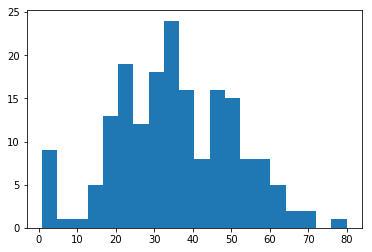

In [0]:
plt.hist(train_df.dropna()['Age'], bins=20)

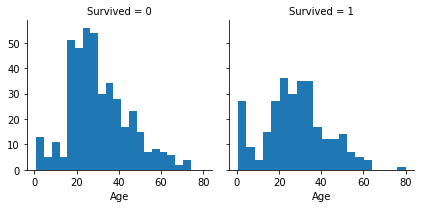

In [0]:
gsurvived = sns.FacetGrid(train_df, col='Survived')
gsurvived.map(plt.hist, 'Age', bins=20)

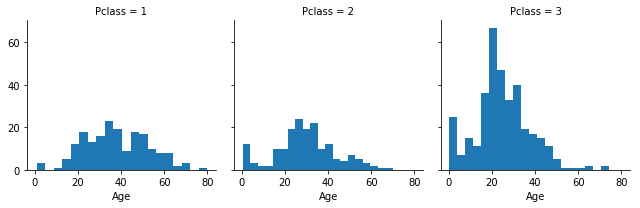

In [0]:
gclass = sns.FacetGrid(train_df, col='Pclass')
gclass.map(plt.hist, 'Age', bins=20)

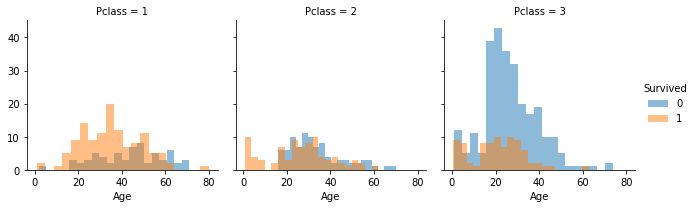

In [0]:
gclasssur = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
gclasssur.map(plt.hist, 'Age', alpha=.5, bins=20)
gclasssur.add_legend()

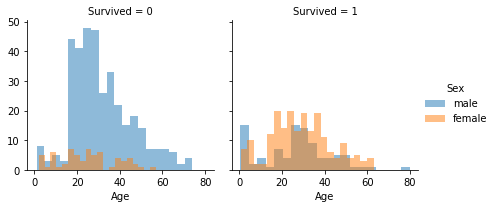

In [0]:
gsex = sns.FacetGrid(train_df, col='Survived', hue='Sex')
gsex.map(plt.hist, 'Age', alpha=.5, bins=20)
gsex.add_legend()

### Observaciones:

* La clase `Sex=female` tuvo una tasa de supervivencia del 0.74. Confirma nustro supuesto #1.
* La mayoría de pasajeros se encuentra entre los 15 y 35 años de edad.
* Un grán número de pasajeros con edades 15-25 no sobrevivieron
* El grupo de edad < 5 tuvieron un alto porcentaje de supervivencia. Confirma nuestro supuesto #2.
* `Pclass=3` tenía la mayoría de los pasajeros, sin embargo la mayoría no sobrevivió.
* Los pasajeros bebés de las clases `Pclase=2` y `Pclase=3` sobrevivieron en su mayoría. Califica aún más nuestro supuesto de clasificación #2.
* La mayoría de los pasajeros en `Pclass=1` sobrevivieron. Confirma nuestro supuesto de clasificación #3.
* La `Pclass` varía en términos de distribución por edades de los pasajeros.

## Otros datos

Además de nuestras 3 suposiciones de correlación, podemos usar visualización para determinar si existe una correlación entre las demás clases y `Survived` con el propósito de incluirlas en nuestro modelo.

Por nuestras observaciones anteriores podemos proponer:

* Crear una clase que contenga grupos de edad para convertir una clase numérica en una clase categórica.

Además de ayudar para la predicción, de igual manera podremos asumir con un alto grado de confianza un grupo de edad para un pasajero que tenga un dato vacío en esta clase.

Las clases que faltan determinar correlación después de nuestras suposiciones y de decidir qué clases desechar serían `SibSp`, `Parch`, `Fare` y `Embarked`. También vamos a desechar `Embarked` para disminuir la complejidad del modelo.

Para el resto de las clases podemos utilizar los mismos criterios para encontrar correlación.

### SibSp y Parch

In [0]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [0]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Algunos valores de estas clases presentan un promedio de `Survived` mayor a 0.5 por lo que podemos deducir una correlación.

Es conveniente sumar estas dos clases en una sola llamada `Family` para tener el número total de familiares a bordo.

### Fare

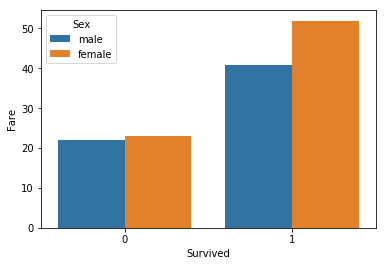

In [0]:
sns.barplot(x='Survived', y='Fare', hue='Sex', data=train_df, ci=None)

Podemos observar que los pasajeros que sobrevibieron pagaron en promedio una tarifa mayor, por lo que sería conveniente definir una nueva clase que tenga grupos de tarifa de manera similar a como hicimos con `Age`.

# Data Wrangling

Ya que hicimos nuestras suposiciones y decisiones acerca de las clases de nuestro dataset debemos ejecutarlas creando o eliminando las clases correspondientes.

## Eliminando datos

Como dijimos en nuestras suposiciones vamos a eliminar `Ticket`, `Cabin`, `PassengerId`, `Name` y `Embarked` (No eliminamos `PassengerId` de `test_df` porque es necesario para introducir en kaggle).

In [0]:
train_df = train_df.drop(columns=['Ticket', 'Cabin', 'PassengerId', 'Name', 'Embarked'])
test_df = test_df.drop(columns=['Ticket', 'Cabin', 'Name', 'Embarked'])
combine = [train_df, test_df]

## Convertir clases categóricas

Debido a la naturaleza de los modelos de `sklearn` vamos a convertir las clases que contienen valores categóricos a numéricos.

In [0]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


## Categorizar números continuos

Además de generar los grupos que mencionamos para `Age` y `Fare` vamos a generar datos para los valores faltantes.

### Age

Podemos usar las otras clases correlacionadas, en este caso `Sex` y `Pclass`, para "adivinar" los valores de edad.

Para el valor de edad faltante vamos a usar la media de edad para ese Género y Clase.

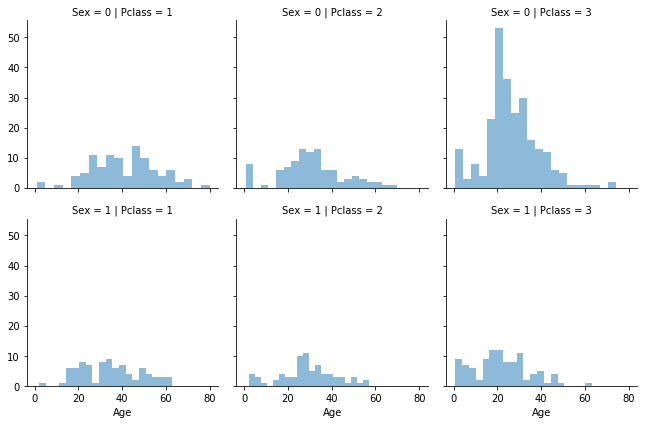

In [0]:
grid = sns.FacetGrid(train_df, col='Pclass', row='Sex')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Vamos a guardar los 6 posibles valores que vamos a adivinar en un array y luego asignarlo a los pasajeros faltantes basado en su `Sex` y `Pclass`.

In [0]:
guess_ages = np.zeros((2,3))

for dataset in combine:
  for i in range(2):
    for j in range(3):
      guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

      age_guess = guess_df.median()

      # Convert random age float to nearest .5 age
      guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

guess_ages

array([[42., 28., 24.],
       [41., 24., 22.]])

In [0]:
for dataset in combine:
  for i in range(2):
    for j in range(3):
      dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

Podemos utilizar la Regla de Sturges para determinar el número de grupos:

$$ k = \log_2 n + 1 $$

In [0]:
np.around(( np.log(train_df.count()[0]) / np.log(2) ) + 1)

11.0

In [0]:
temp_df = pd.DataFrame()
temp_df['Survived'] = train_df['Survived']
temp_df['AgeBand'] = pd.cut(train_df['Age'],10)
temp_df.groupby(['AgeBand'], as_index=False).mean()

,AgeBand,Survived
0,"(0.34, 8.378]",0.666667
1,"(8.378, 16.336]",0.413043
2,"(16.336, 24.294]",0.314286
3,"(24.294, 32.252]",0.376404
4,"(32.252, 40.21]",0.440678
5,"(40.21, 48.168]",0.380000
6,"(48.168, 56.126]",0.466667
7,"(56.126, 64.084]",0.375000
8,"(64.084, 72.042]",0.000000
9,"(72.042, 80.0]",0.500000


In [0]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 8, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 8) & (dataset['Age'] <= 16), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 24), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 40), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 48), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 56), 'Age'] = 6
    dataset.loc[(dataset['Age'] > 56) & (dataset['Age'] <= 64), 'Age'] = 7
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 72), 'Age'] = 8
    dataset.loc[ dataset['Age'] > 72, 'Age'] = 9

In [0]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,2.0,1,0,7.2500
1,1,1,1,4.0,1,0,71.2833
2,1,3,1,3.0,0,0,7.9250
3,1,1,1,4.0,1,0,53.1000
4,0,3,0,4.0,0,0,8.0500


### Fare

Podemos completar `Fare` con la media, y categorizarlo de manera similar a `Age`.

In [0]:
for dataset in combine:
  dataset['Fare'].fillna(dataset['Fare'].dropna().median(), inplace=True)

test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,0,4.0,0,0,7.8292
1,893,3,1,5.0,1,0,7.0000
2,894,2,0,7.0,0,0,9.6875
3,895,3,0,3.0,0,0,8.6625
4,896,3,1,2.0,1,1,12.2875


Para crear los rangos usamos:

```py
pd.qcut()
```
Ya que tenemos un par de datos atípicos que de otra manera harían la agrupación demasiado general.

In [0]:
temp_df['FareBand'] = pd.qcut(train_df['Fare'],5)
temp_df.groupby(['FareBand'], as_index=False).mean()

,FareBand,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


In [0]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.85, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.85) & (dataset['Fare'] <= 10.5), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 10.5) & (dataset['Fare'] <= 21.68), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 21.68) & (dataset['Fare'] <= 39.69), 'Fare']   = 3
    dataset.loc[ dataset['Fare'] > 39.69, 'Fare'] = 4
    dataset['Fare'] = dataset['Fare'].astype(int)

## Combinar clases

Vamos a combinar `SibSp` y `Parch` en una nueva clase `Family`.

In [0]:
for dataset in combine:
  dataset['Family'] = dataset['SibSp'] + dataset['Parch']
  dataset.drop(columns=['SibSp', 'Parch'])

train_df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


## Datos Finales

In [0]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family
0,0,3,0,2.0,1,0,0,1
1,1,1,1,4.0,1,0,4,1
2,1,3,1,3.0,0,0,1,0
3,1,1,1,4.0,1,0,4,1
4,0,3,0,4.0,0,0,1,0


In [0]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Family
0,892,3,0,4.0,0,0,0,0
1,893,3,1,5.0,1,0,0,1
2,894,2,0,7.0,0,0,1,0
3,895,3,0,3.0,0,0,1,0
4,896,3,1,2.0,1,1,2,2


# Entrenamiento

Para este problema vamos a utilizar el modelo de clasificación lineal `LinearSVC`

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
linear_svc = LinearSVC()

linear_svc.fit(X_train, y_train)

print("Train score: ", linear_svc.score(X_train, y_train))
print("Test score: ", linear_svc.score(X_test, y_test))

Train score:  0.7904191616766467
Test score:  0.8340807174887892


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
y_pred = linear_svc.predict(test_df.drop(columns=['PassengerId']))

submission = pd.DataFrame({
    "PassengerId": test_df['PassengerId'],
    "Survived": y_pred
})

submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [0]:
submission.to_csv('titanic2.csv', index=False)